# 04. PyTorch Custom Datasets Exercises Template

In [1]:
# Check for GPU
!nvidia-smi

Wed Nov 20 16:35:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.5.1+cu121


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)


Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.


In [6]:
# Setup train and testing paths
train_dir = image_path /"train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/test/sushi/3177743.jpg
Image class: sushi
Image height: 512
Image width: 512


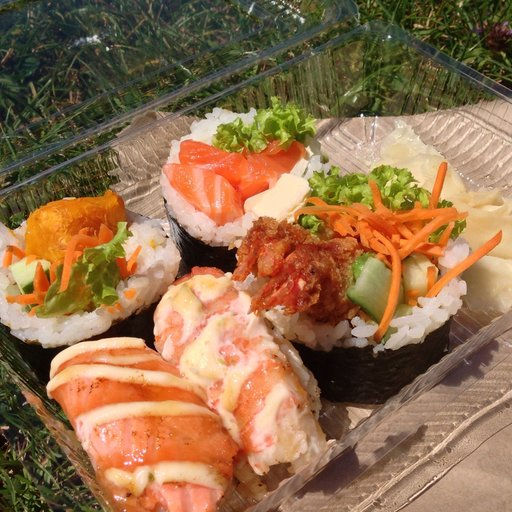

In [7]:
# Visualize an image
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all the images from the path
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class name from path
image_class = random_image_path.parent.stem

# 4. Open Image
img = Image.open(random_image_path)

# Print Metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

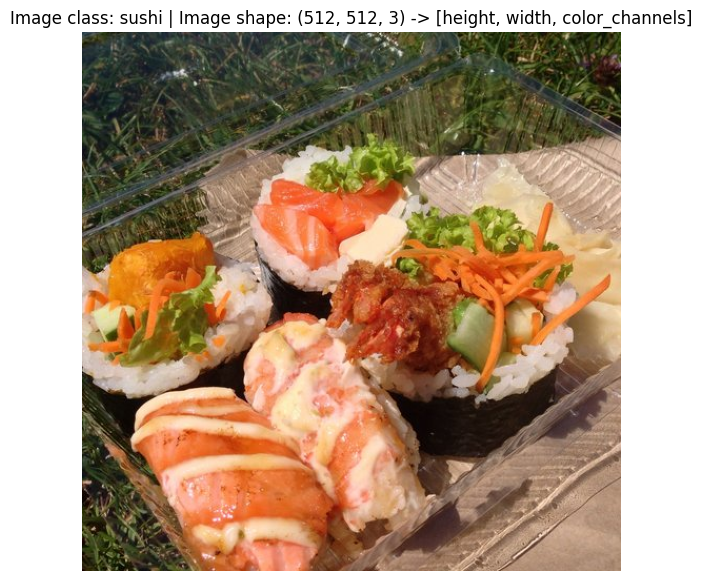

In [8]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image in to an array
img_as_array = np.asanyarray(img)

# Plot image with plt
plt.figure(figsize = (10, 7 ))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [9]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
    # Resize the image to 64 X 64
    transforms.Resize(size = (64, 64)),

    # Horizontal flip
    transforms.RandomHorizontalFlip(p=0.5),

    # Convert to Tensor
    transforms.ToTensor()
])

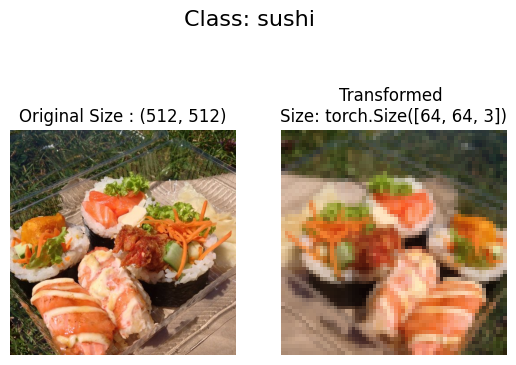

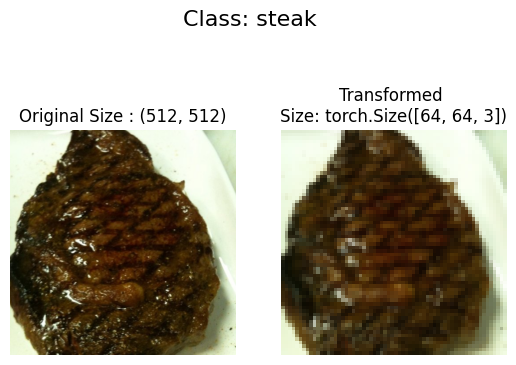

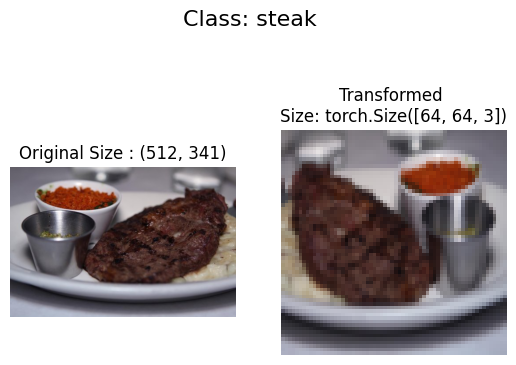

In [11]:
# Write a function to plot transformed images

def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_path = random.sample(image_paths, k=n)

    for image_path in random_image_path:
      with Image.open(image_path) as f:
        fig, ax  =  plt.subplots(1, 2)
        ax[0].imshow(f)
        ax[0].set_title(f"Original Size : {f.size}")
        ax[0].axis("off")

        # Transform and plot
        # PyTorch default is [C,H,W]
        # Matplotlib expects is [H, W, C]
        transformed_image = transform(f).permute(1,2,0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
        ax[1].axis("off")

        fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)


### Load image data using `ImageFolder`

In [12]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(
    root = train_dir,
    transform=data_transform,
    target_transform=None
)

test_data = datasets.ImageFolder(
    root = test_dir,
    transform = data_transform
)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [13]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [16]:
# Turn train and test Datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()


train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = True,
    pin_memory = True
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = False,
    pin_memory = True
)

In [17]:
# How many batches of images are in our data loaders?
len(train_dataloader), len(test_dataloader)

(8, 3)

In [18]:

img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [19]:
# TinyVGG Architecture
import torch
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self,
               input_shape:int,
               output_shape: int,
               hidden_units: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1
                  ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels = hidden_units,
            out_channels = hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(
            in_channels = hidden_units,
            out_channels  = hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 1,
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels = hidden_units,
            out_channels = hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 1
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features = hidden_units * 16 * 16,
            out_features = output_shape
        )
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))
  # def forward(self, x):
  #   x = self.conv_block_1(x)
  #   print(f"Layer 1 shape: {x.shape}")
  #   x = self.conv_block_2(x)
  #   print(f"Layer 2 shape: {x.shape}")
  #   x = self.classifier(x)
  #   print(f"Layer 3 shape: {x.shape}")
  #   return x

In [20]:
model_0 = TinyVGG(input_shape = 3, hidden_units = 10, output_shape = len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [21]:
pip install torchinfo

In [22]:
from torchinfo import summary

# get summary
summary(model_0, input_size = [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [23]:
# Pass dummy data through model
dummy_x = torch.rand(size=[1, 3, 64, 64])
model_0(dummy_x.to(device))

tensor([[ 0.0074, -0.0013,  0.0013]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

## 4. Create training and testing functions for `model_0`.

In [24]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [25]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)
      # print(test_pred_logits)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


In [26]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [27]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = TinyVGG(
    input_shape = 3,
    hidden_units= 10,
    output_shape = len(class_names)
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2695 | test_loss: 1.1380 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0828 | train_acc: 0.4258 | test_loss: 1.1681 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1203 | train_acc: 0.2930 | test_loss: 1.1727 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0949 | train_acc: 0.4141 | test_loss: 1.1416 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0945 | train_acc: 0.2930 | test_loss: 1.1405 | test_acc: 0.1979


In [28]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = TinyVGG(
    input_shape = 3,
    hidden_units= 10,
    output_shape = len(class_names)
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2695 | test_loss: 1.1380 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0828 | train_acc: 0.4258 | test_loss: 1.1681 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1203 | train_acc: 0.2930 | test_loss: 1.1727 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0949 | train_acc: 0.4141 | test_loss: 1.1416 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0945 | train_acc: 0.2930 | test_loss: 1.1405 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.0920 | train_acc: 0.3555 | test_loss: 1.1456 | test_acc: 0.2708
Epoch: 7 | train_loss: 1.1060 | train_acc: 0.4180 | test_loss: 1.1308 | test_acc: 0.2396
Epoch: 8 | train_loss: 1.0717 | train_acc: 0.3789 | test_loss: 1.0825 | test_acc: 0.4545
Epoch: 9 | train_loss: 1.0172 | train_acc: 0.6406 | test_loss: 1.0325 | test_acc: 0.5549
Epoch: 10 | train_loss: 0.9554 | train_acc: 0.6328 | test_loss: 0.9945 | test_acc: 0.5142
Epoch: 11 | train_loss: 0.8966 | train_acc: 0.5039 | test_loss: 1.0013 | test_acc: 0.4328
Epoch: 12 | train_l

In [29]:
# Train for 50 epochs
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = TinyVGG(
    input_shape = 3,
    hidden_units= 10,
    output_shape = len(class_names)
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2695 | test_loss: 1.1380 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0828 | train_acc: 0.4258 | test_loss: 1.1681 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1203 | train_acc: 0.2930 | test_loss: 1.1727 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0949 | train_acc: 0.4141 | test_loss: 1.1416 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0945 | train_acc: 0.2930 | test_loss: 1.1405 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.0920 | train_acc: 0.3516 | test_loss: 1.1457 | test_acc: 0.2708
Epoch: 7 | train_loss: 1.1061 | train_acc: 0.4180 | test_loss: 1.1308 | test_acc: 0.2396
Epoch: 8 | train_loss: 1.0715 | train_acc: 0.3828 | test_loss: 1.0825 | test_acc: 0.4545
Epoch: 9 | train_loss: 1.0166 | train_acc: 0.6367 | test_loss: 1.0319 | test_acc: 0.5549
Epoch: 10 | train_loss: 0.9627 | train_acc: 0.6289 | test_loss: 0.9963 | test_acc: 0.5038
Epoch: 11 | train_loss: 0.8985 | train_acc: 0.4961 | test_loss: 0.9928 | test_acc: 0.4744
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [31]:
# Double the number of hidden units and train for 20 epochs
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = TinyVGG(
    input_shape = 3,
    hidden_units= 20,
    output_shape = len(class_names)
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1048 | train_acc: 0.4219 | test_loss: 1.1072 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1218 | train_acc: 0.3047 | test_loss: 1.0979 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0913 | train_acc: 0.3867 | test_loss: 1.1001 | test_acc: 0.2188
Epoch: 4 | train_loss: 1.0957 | train_acc: 0.4180 | test_loss: 1.0824 | test_acc: 0.5350
Epoch: 5 | train_loss: 1.0850 | train_acc: 0.4531 | test_loss: 1.0705 | test_acc: 0.3125
Epoch: 6 | train_loss: 1.0484 | train_acc: 0.5664 | test_loss: 1.0866 | test_acc: 0.3731
Epoch: 7 | train_loss: 0.9840 | train_acc: 0.4609 | test_loss: 1.0503 | test_acc: 0.3324
Epoch: 8 | train_loss: 0.8753 | train_acc: 0.6211 | test_loss: 1.0272 | test_acc: 0.4138
Epoch: 9 | train_loss: 0.9266 | train_acc: 0.4727 | test_loss: 0.9182 | test_acc: 0.5464
Epoch: 10 | train_loss: 0.9504 | train_acc: 0.5078 | test_loss: 0.9846 | test_acc: 0.4432
Epoch: 11 | train_loss: 0.8946 | train_acc: 0.6172 | test_loss: 1.0741 | test_acc: 0.4441
Epoch: 12 | train_l

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [32]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [33]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.


Excellent, we now have double the training and testing images...

In [34]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [35]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

train_data_20_percent = ImageFolder(train_data_20_percent_path,
                                    transform=simple_transform)

test_data_20_percent = ImageFolder(test_data_20_percent_path,
                                   transform=simple_transform)

# Create dataloaders
train_dataloader_20_percent = DataLoader(train_data_20_percent,
                                         batch_size=32,
                                         num_workers=os.cpu_count(),
                                         shuffle=True)

test_dataloader_20_percent = DataLoader(test_data_20_percent,
                                        batch_size=32,
                                        num_workers=os.cpu_count(),
                                        shuffle=False)


In [36]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_4 = TinyVGG(input_shape=3,
                  hidden_units=20, # use 20 hidden units instead of 10
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)

model_4_results = train(model=model_4,
                        train_dataloader=train_dataloader_20_percent, # use double the training data
                        test_dataloader=test_dataloader_20_percent, # use double the testing data
                        optimizer=optimizer,
                        epochs=20) # train for 20 epochs

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1042 | train_acc: 0.3312 | test_loss: 1.1003 | test_acc: 0.2875
Epoch: 2 | train_loss: 1.0837 | train_acc: 0.3583 | test_loss: 1.0710 | test_acc: 0.3551
Epoch: 3 | train_loss: 1.0299 | train_acc: 0.4417 | test_loss: 0.9534 | test_acc: 0.5358
Epoch: 4 | train_loss: 0.9175 | train_acc: 0.5437 | test_loss: 0.9243 | test_acc: 0.5722
Epoch: 5 | train_loss: 0.8734 | train_acc: 0.6188 | test_loss: 0.9188 | test_acc: 0.5494
Epoch: 6 | train_loss: 0.8452 | train_acc: 0.6021 | test_loss: 1.0520 | test_acc: 0.4403
Epoch: 7 | train_loss: 0.9210 | train_acc: 0.5437 | test_loss: 0.9080 | test_acc: 0.5210
Epoch: 8 | train_loss: 0.7793 | train_acc: 0.6542 | test_loss: 0.9224 | test_acc: 0.5892
Epoch: 9 | train_loss: 0.8017 | train_acc: 0.6458 | test_loss: 0.9286 | test_acc: 0.5364
Epoch: 10 | train_loss: 0.7966 | train_acc: 0.6458 | test_loss: 0.8830 | test_acc: 0.6068
Epoch: 11 | train_loss: 0.7619 | train_acc: 0.6646 | test_loss: 0.8689 | test_acc: 0.6097
Epoch: 12 | train_l

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [37]:
# Get a custom image
custom_image = "pizza_dad.jpeg"
with open("pizza_dad.jpeg", "wb") as f:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
  f.write(request.content)

In [38]:
# Load the image
import torchvision
img = torchvision.io.read_image(custom_image)
img

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

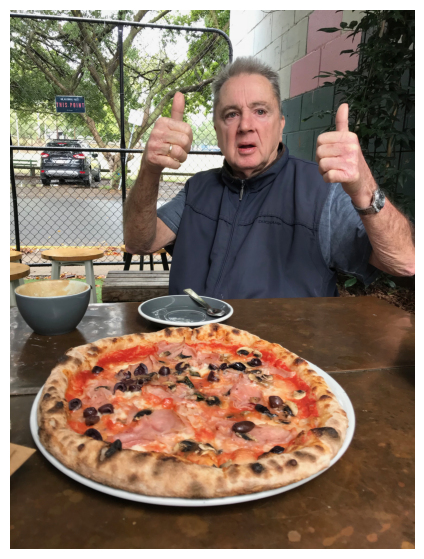

In [39]:
# View the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in HWC (height, width, color_channels) format not CHW (color_channels, height, width)
plt.axis(False);

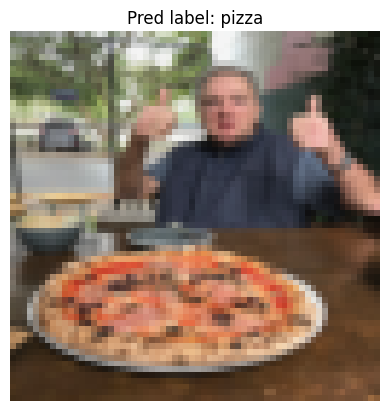

In [40]:
# Make a prediction on the image
model_4.eval()
with torch.inference_mode():
  # Get image pixels into float + between 0 and 1
  img = img / 255.

  # Resize image to 64x64
  resize = transforms.Resize((64, 64))
  img = resize(img)

  # Turn image in single batch and pass to target device
  batch = img.unsqueeze(0).to(device)

  # Predict on image
  y_pred_logit = model_4(batch)

  # Convert pred logit to pred label
  # pred_label = torch.argmax(torch.softmax(y_pred_logit, dim=1), dim=1)
  pred_label = torch.argmax(y_pred_logit, dim=1) # get same results as above without torch.softmax

# Plot the image and prediction
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Pred label: {class_names[pred_label]}")
plt.axis(False);